# Levy Processes and Applications
## Stochastic Volatility Model: NIG-CIR
### Date: 26/10/2024
### Group Components: 
- Tornike Kikacheishvili - 60762
- Simone Fabbri - 63292
- Pouria Baharizadeh - 63263
- Ibrahim Bamba - 63254
- Rodrigo Orozco Perez - 60348

## 0.Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.stats import norm
from scipy.optimize import brentq
import statistics

np.random.seed(42)  # Set seed for reproducibility

## 1. Simulation of the process

### 1.1 Simulation of Brownian motion

In [3]:
def brownian_motion(time_array):
    """
    Generate a Brownian motion (Wiener process) given a time array.
    
    Parameters:
        time_array (numpy array): Array of time points for which to generate the Brownian motion.
    
    Returns:
        numpy array: Array representing the Brownian motion process at each time in time_array.
    """
    # Calculate time increments
    dt = np.diff(time_array)  # time intervals
    dt = np.insert(dt, 0, 0)  # ensure first element is 0
    # Generate random increments (normal distribution with mean 0 and variance dt)
    dW = np.sqrt(dt) * np.random.normal(0, 1, len(time_array))
    # Calculate Brownian motion as cumulative sum of increments
    W = np.cumsum(dW)
    return W

#### Test function

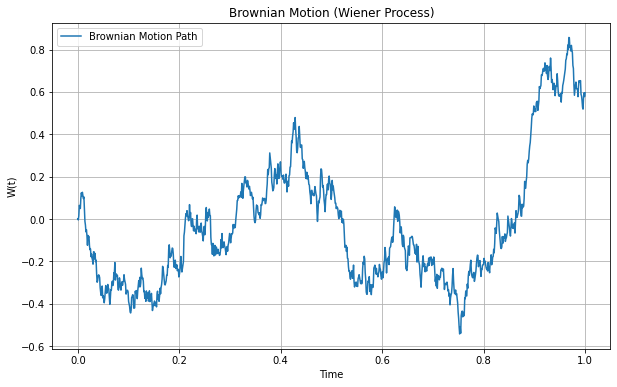

In [4]:
# Create a time array with 1000 equally spaced steps from 0 to 1
time_array = np.linspace(0, 1, 1000)
# Generate Brownian motion for the given time array
brownian_path = brownian_motion(time_array)
# Plot the Brownian motion path
plt.figure(figsize=(10, 6))
plt.plot(time_array, brownian_path, label="Brownian Motion Path")
plt.title("Brownian Motion (Wiener Process)")
plt.xlabel("Time")
plt.ylabel("W(t)")
plt.legend()
plt.grid(True)
plt.show()

### 1.2 Simulation of the CIR process

In [6]:
def get_CIR(kappa, eta, lambda_, y0, T, N):
    """
    Generates a Cox-Ingersoll-Ross (CIR) process.

    Parameters:
    kappa (float): Mean reversion speed.
    eta (float): Long-term mean.
    lambda_ (float): Volatility.
    y0 (float): Initial value.
    T (float): Time horizon.
    N (int): Number of time steps.

    Returns:
    numpy.ndarray: Simulated CIR process.
    """
    # Time step size
    dt = (1 / 252)
    # Time grid
    t = np.linspace(0, T, N)
    # Initialize the process
    y = np.zeros(N)
    y[0] = y0
    # Simulate the CIR process
    for i in range(1, N):
        vn = np.random.randn()  # Standard normal random variable
        y[i] = y[i - 1] + kappa * (eta - y[i - 1]) * dt + lambda_ * np.sqrt(y[i - 1]) * np.sqrt(dt) * vn
        # Ensure non-negativity
        y[i] = max(y[i], 0)
    return y

def get_ICIR(y):
    """
    Integrates a CIR process by computing the cumulative sum up to each point.

    Parameters:
    y (numpy.ndarray): CIR process vector.

    Returns:
    numpy.ndarray: Integrated CIR process (cumulative sum).
    """
    # Compute cumulative sum (integrated process)
    integrated_y = np.cumsum(y)
    return integrated_y


#### Test function

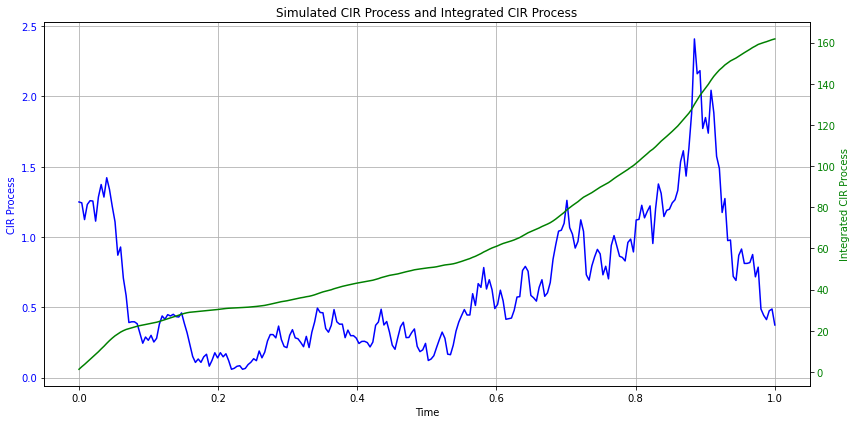

In [18]:
# Test parameters
kappa = 5     # Mean reversion speed
eta = 1       # Long-term mean
lambda_ = 2   # Volatility
y0 = 1.25     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
# Generate the CIR process
y = get_CIR(kappa, eta, lambda_, y0, T, N)
# Integrate the CIR process
integrated_y = get_ICIR(y)
# Time grid
t = np.linspace(0, T, N)
# Plot CIR and Integrated CIR on separate y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot CIR process on the primary y-axis
ax1.plot(t, y, label="CIR Process", color="blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("CIR Process", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)
# Plot Integrated CIR on the secondary y-axis
ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis
ax2.plot(t, integrated_y, label="Integrated CIR Process", color="green")
ax2.set_ylabel("Integrated CIR Process", color="green")
ax2.tick_params(axis="y", labelcolor="green")
# Title and show plot
plt.title("Simulated CIR Process and Integrated CIR Process")
fig.tight_layout()
plt.show()

### 1.3 Simulation of the Inverse Gaussian Process

In [19]:
def get_number_IG(a, b): 
    """
    Generates a random number from an inverse Gaussian (IG) distribution with parameters a and b.

    Parameters:
    a (float): The mean of the IG distribution.
    b (float): The shape parameter of the IG distribution.

    Returns:
    float: A random number from the inverse Gaussian distribution.
    """
    # Step 1: Generate a standard normal random variable
    z = np.random.randn()
    # Step 2: Compute y = z^2
    y = z ** 2
    # Step 3: Compute the potential IG values
    x = (a / b) + (y / (2 * b * b)) - np.sqrt((4 * a * b * y) + (y * y)) / (2 * b * b)
    # Step 4: Generate a uniform random variable
    u = np.random.rand()
    # Step 5: Return x or x_alt based on the condition
    if(a==0):
        return 0
    return x if u <= a / (a + x * b) else (a * a) / (b * b * x)  # Alternative value based on inverse relationship

def get_IG(t, a, b):
    """
    Simulates an Inverse Gaussian (IG) process over non-equidistant time steps.

    Parameters:
    t (array-like): Array of time steps (not necessarily equally spaced).
    a (float): Mean parameter for the IG distribution.
    b (float): Shape parameter for the IG distribution.

    Returns:
    numpy.ndarray: The IG process values at each time step in t.
    """
    # Initialize the IG process array
    IG_process = np.zeros(len(t))
    # Simulate IG increments for each time step
    for i in range(1, len(t)):
        delta_t = t[i] - t[i - 1]
        IG_increment = get_number_IG(a * delta_t, b)
        IG_process[i] = IG_process[i - 1] + IG_increment  # Cumulative sum for process
    return IG_process

def get_IG_CIR(kappa, eta, lambda_, y0, T, N, a, b):
    """
    Simulates an Inverse Gaussian (IG) process time changed using a CIR process.

    Parameters:
    kappa (float): Mean reversion speed of the CIR.
    eta (float): Long-term mean of the CIR.
    lambda_ (float): Volatility of the CIR.
    y0 (float): Initial value of the CIR.
    T (float): Time horizon of the CIR.
    N (int): Number of time steps of the CIR.
    a (float): Mean parameter for the IG distribution.
    b (float): Shape parameter for the IG distribution.

    Returns:
    numpy.ndarray: The IG process values at each time step in t.
    """
    # Generate the CIR process
    time = get_ICIR(get_CIR(kappa, eta, lambda_, y0, T, N))*1/252
    return time, get_IG(time, a, b)



#### Test function

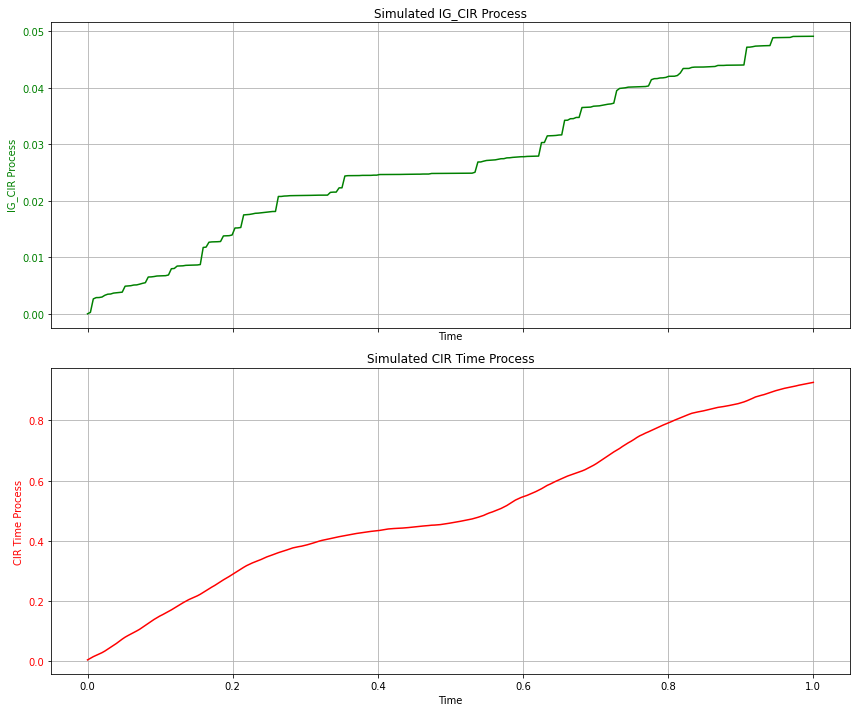

In [28]:
# Test parameters CIR
kappa = 5     # Mean reversion speed
eta = 1       # Long-term mean
lambda_ = 2   # Volatility
y0 = 1.25     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
# Test parameters for the Inverse Gaussian (IG) process
a = 1  # Mean parameter
b = 20  # Shape parameter
# Generate the IG process using CIR time array
t = np.linspace(0, T, N)
IG_process = get_IG(t, a, b)
time_ICIR, IG_CIR_process = get_IG_CIR(kappa, eta, lambda_, y0, T, N, a, b)
# Plot IG and IG_CIR on separate y-axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)  # Create a 2x1 grid of subplots
# Plot IG_CIR process on the first subplot
ax1.plot(t, IG_CIR_process, label="IG_CIR Process", color="green")
ax1.set_xlabel("Time")
ax1.set_ylabel("IG_CIR Process", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(True)
ax1.set_title("Simulated IG_CIR Process")
# Plot CIR Time process on the second subplot
ax2.plot(t, time_ICIR, label="CIR Time Process", color="red")
ax2.set_xlabel("Time")
ax2.set_ylabel("CIR Time Process", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.grid(True)
ax2.set_title("Simulated CIR Time Process")
# Adjust layout to avoid overlap and show the plot
fig.tight_layout()
plt.show()

### 1.4 Simulation of the Normal Inverse Gaussian Process

In [29]:
def get_NIG(t, alpha, beta, delta):
    """
    Generate a Normal Inverse Gaussian (NIG) process.
    
    Parameters:
        t: time process of the underlying Inverse Gaussian process.
        alpha (float): Tail heaviness parameter for the NIG process.
        beta (float): Asymmetry parameter for the NIG process.
        delta (float): Scale parameter for the NIG process.
    
    Returns:
        numpy array: Array representing the NIG process at each point in the inverse Gaussian process.
    """
    # Generate the underlying Inverse Gaussian time process
    a = 1
    b = delta * np.sqrt(alpha*alpha - beta*beta)
    inv_gaussian_process = get_IG(t, a, b)
    # Generate Brownian motion for the time array defined by the inverse Gaussian process
    W_G = brownian_motion(inv_gaussian_process)
    # Compute the NIG process
    X_t = beta * delta * delta * inv_gaussian_process + delta * W_G
    return t, X_t


def get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta):
    """
    Generate a Normal Inverse Gaussian (NIG) process.
    
    Parameters:
        kappa (float): Mean reversion speed of the CIR.
        eta (float): Long-term mean of the CIR.
        lambda_ (float): Volatility of the CIR.
        y0 (float): Initial value of the CIR.
        T (float): Time horizon of the CIR.
        N (int): Number of time steps of the CIR.
        alpha (float): Tail heaviness parameter for the NIG process.
        beta (float): Asymmetry parameter for the NIG process.
        delta (float): Scale parameter for the NIG process.
    
    Returns:
        numpy array: Array representing the NIG process at each point in the inverse Gaussian process.
    """
    # Generate the CIR process (time process of the underlying Inverse Gaussian Process)
    time_CIR = get_ICIR(get_CIR(kappa, eta, lambda_, y0, T, N))*1/252
    return get_NIG(time_CIR, alpha, beta, delta)


#### Test function (using Schoutens' book parameters)

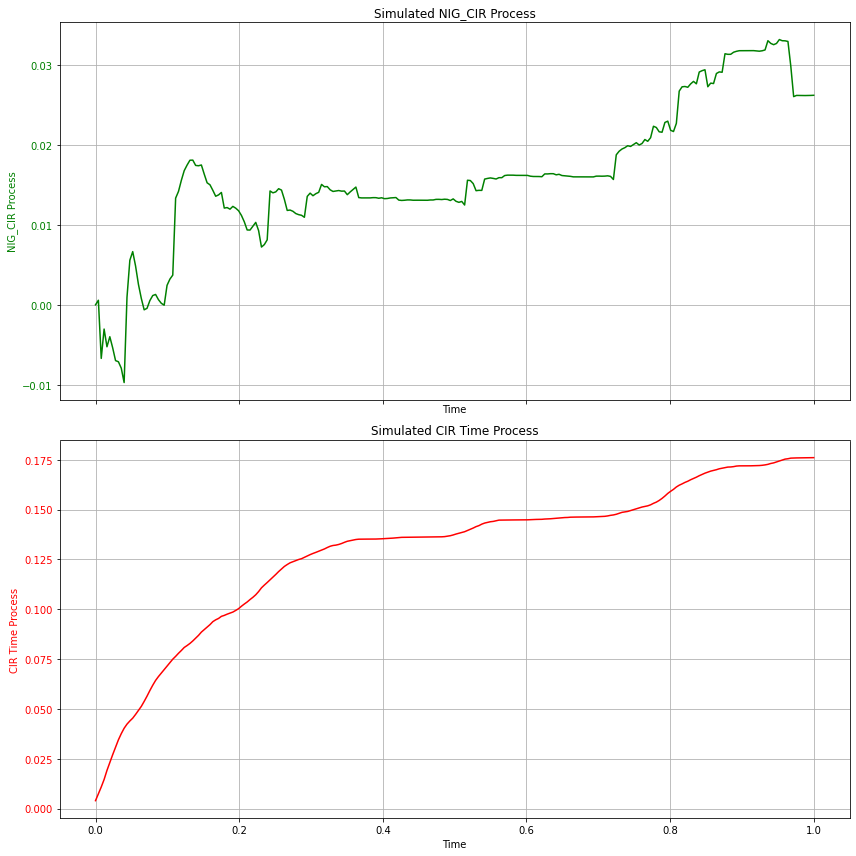

In [42]:
# Test parameters CIR
kappa = 0.5391     # Mean reversion speed
eta = 1.5746       # Long-term mean
lambda_ = 1.8772   # Volatility
y0 = 1     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
# Test parameters for the Inverse Gaussian (IG) process
alpha = 18.4815 #Tail heaviness parameter for the NIG process.
beta = -4.8412 #Asymmetry parameter for the NIG process.
delta = 0.4685 #Scale parameter for the NIG process.
# Generate the IG process using CIR time array
t = np.linspace(0, T, N)
time_ICIR, NIG_CIR_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
NIG_process = get_NIG(t, alpha, beta, delta)
# Plot NIG and IRCIR on separate y-axes
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)  # Create a 3x1 grid of subplots
# Plot NIG_CIR process on the second subplot
ax2.plot(t, NIG_CIR_process, label="NIG_CIR Process", color="green")
ax2.set_xlabel("Time")
ax2.set_ylabel("NIG_CIR Process", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.grid(True)
ax2.set_title("Simulated NIG_CIR Process")
# Plot CIR Time process on the third subplot
ax3.plot(t, time_ICIR, label="CIR Time Process", color="red")
ax3.set_xlabel("Time")
ax3.set_ylabel("CIR Time Process", color="red")
ax3.tick_params(axis="y", labelcolor="red")
ax3.grid(True)
ax3.set_title("Simulated CIR Time Process")
# Adjust layout to avoid overlap and show the plot
fig.tight_layout()
plt.show()

### 1.5 Simulation of the NIG-CIR Levy Process

#### Calculation of the risk-neutral correction

In [43]:
def risk_neutral (r, q, u, t, kappa, eta, lambda_, y0):
    # Calculate exp_iuYt_y0
    # new u (suggested by professor)
    #u = -1*delta*(cmath.sqrt(alpha*alpha-(beta+1)**2) - cmath.sqrt(alpha*alpha-beta*beta))
    # Calculate gamma (γ)
    if(t>0):
        gamma = math.sqrt(kappa*kappa - 2 * (lambda_*lambda_) * u)
        # Calculate the expression
        numerator = math.exp((kappa*kappa * eta * t) / (lambda_*lambda_)) * math.exp((2 * y0 * u) / (kappa + gamma * (math.cosh(gamma * t / 2)/math.sinh(gamma * t / 2))))
        denominator = (math.cosh(gamma * t / 2) + (kappa * math.sinh(gamma * t / 2)) / gamma) ** (2 * kappa * eta / (lambda_**2))
        exp_iuYt_y0 = numerator / denominator
        result = ((math.exp((r-q)*t))/exp_iuYt_y0)
    else: 
        return 1
    
    return result

def apply_risk_neutral (r, q, u, tarray, price_process, kappa, eta, lambda_, y0):
    i=0
    copyprocess = price_process
    for element in tarray:
        risk_neutral_ = risk_neutral (r, q, u, element, kappa, eta, lambda_, y0)
        copyprocess[i]=copyprocess[i]*risk_neutral_
        i=i+1
    return copyprocess


#### Simulation of possible NIG CIR processes from the close of the market on April 18th 2002 to April 18th 2003.

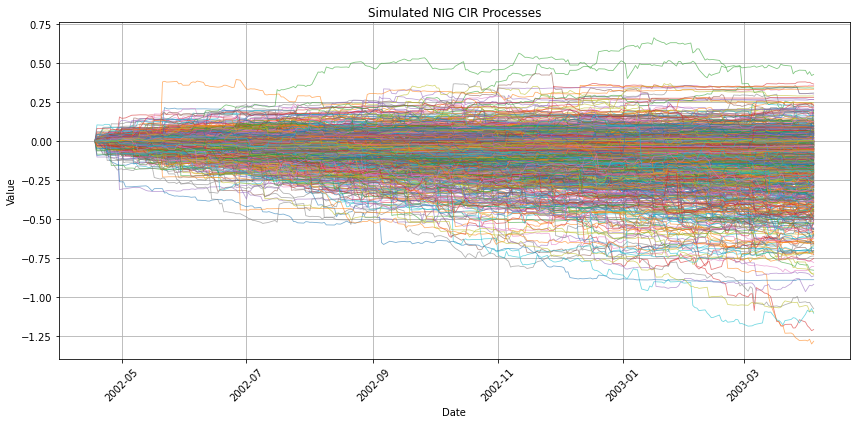

In [49]:
#Schoutens' book: NIG_CIR Parameters
kappa = 0.5391     # Mean reversion speed CIR
eta = 1.5746       # Long-term mean CIR
lambda_ = 1.8772   # Volatility CIR
y0 = 1     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
alpha = 18.4815 #Tail heaviness parameter for the NIG process.
beta = -4.8412 #Asymmetry parameter for the NIG process.
delta = 0.4685 #Scale parameter for the NIG process.
num_paths = 1000  # Number of trajectories
# Set the starting date for the x-axis
start_date = pd.to_datetime("2002-04-18")
dates = pd.date_range(start=start_date, periods=N, freq='B')  # Business days only
# Initialize an array to store paths
paths = np.zeros((N, num_paths))
# Simulate each path
for i in range(num_paths):
    # Generate a new set of daily log returns for this trajectory
    time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
    paths[0:, i] = levy_process  # Convert log returns to price path
# Plot the 100 simulated paths
plt.figure(figsize=(12, 6))
for i in range(num_paths):
    plt.plot(dates, paths[:, i], linewidth=0.8, alpha=0.6)
plt.title("Simulated NIG CIR Processes")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Results when parameters are changed

In [50]:
# Function to plot trajectories with modified parameters
def plot_simulations(kappa, eta, lambda_, alpha, beta, delta, title, ax):
    # Initialize an array to store paths
    paths = np.zeros((N, num_paths))
    # Simulate each path
    for i in range(num_paths):
        time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
        paths[:, i] = levy_process
    # Plot the paths
    for i in range(num_paths):
        ax.plot(dates, paths[:, i], linewidth=0.8, alpha=0.6)
    # Formatting
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.grid(True)

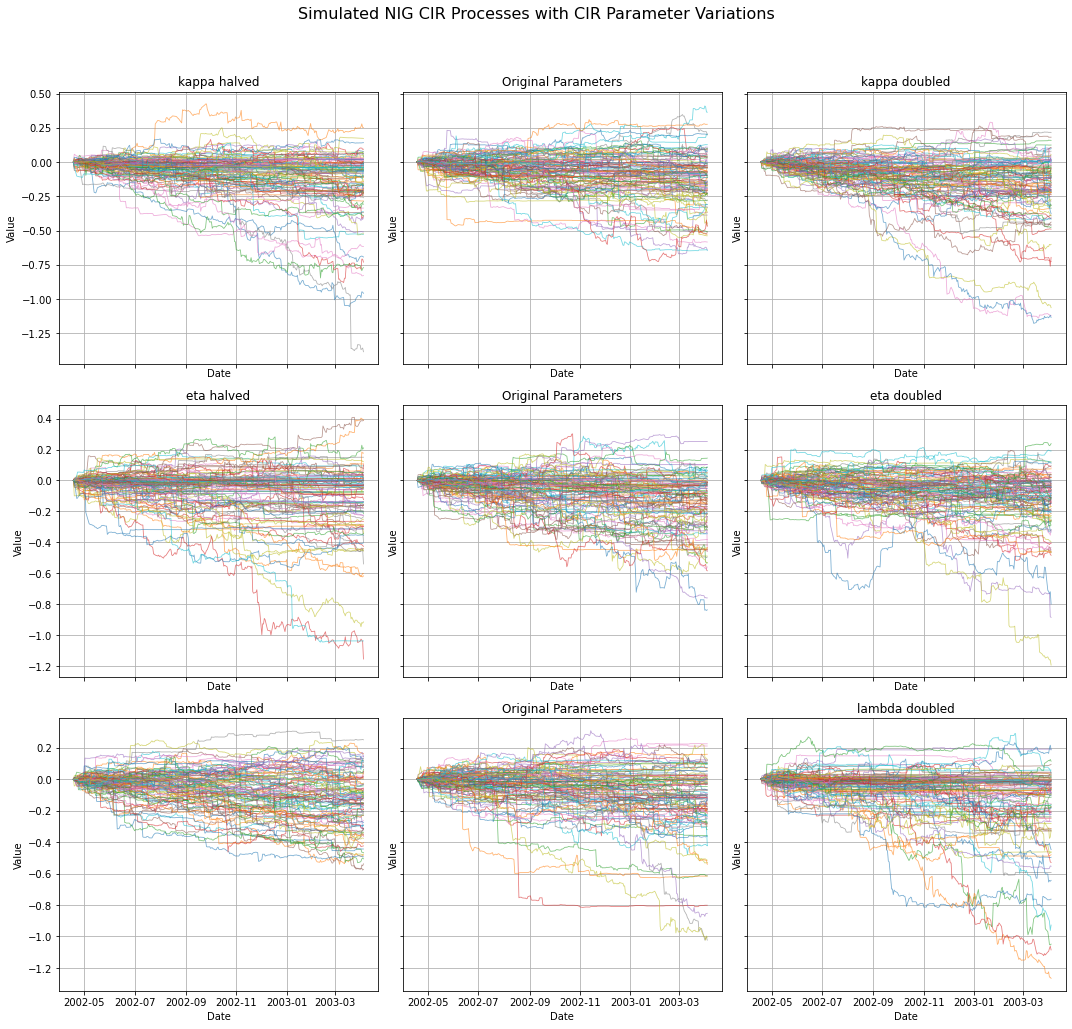

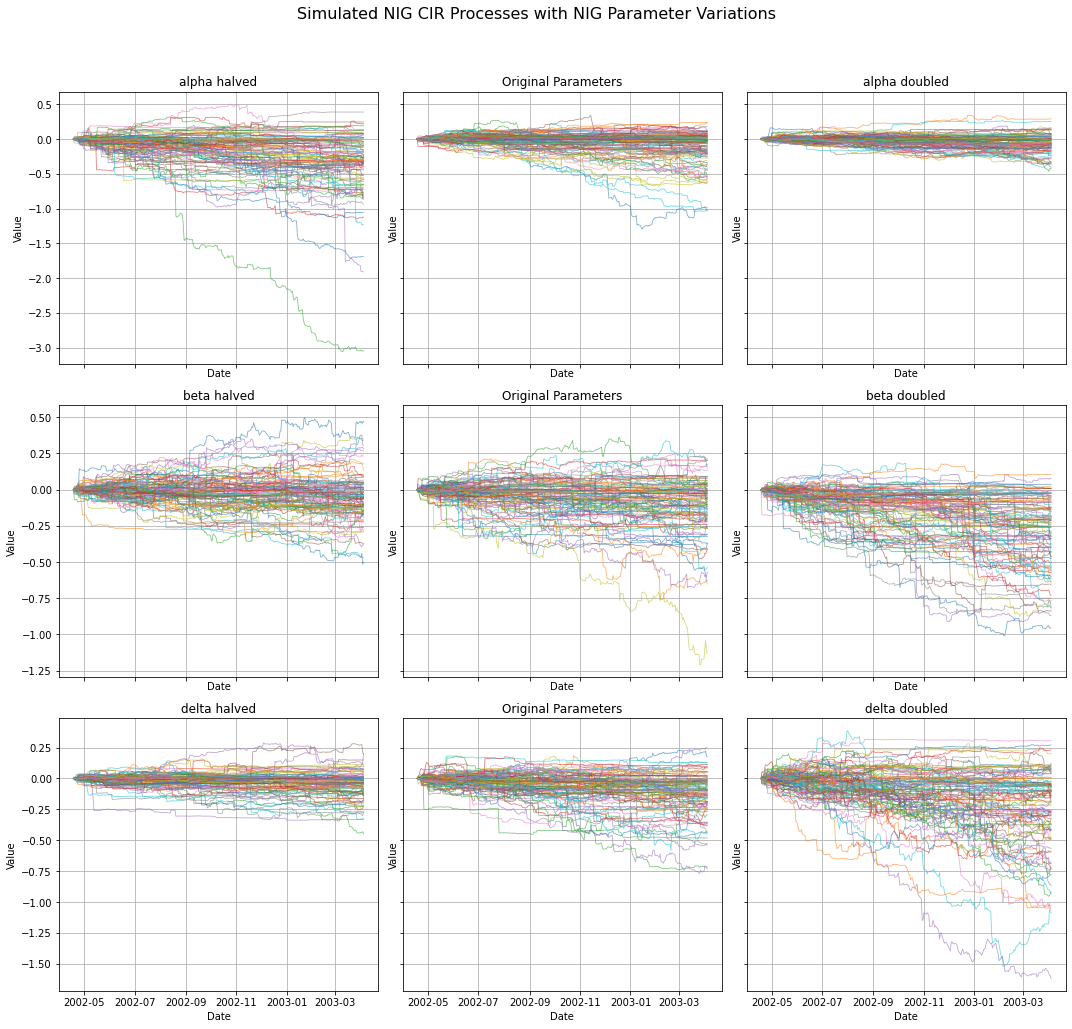

In [61]:
# Original parameters (Schoutens' book: NIG_CIR Parameters)
kappa = 0.5391     # Mean reversion speed
eta = 1.5746       # Long-term mean
lambda_ = 1.8772   # Volatility
y0 = 1             # Initial value
T = 1.0            # Time horizon
N = 252            # Number of time steps
alpha = 18.4815    # Tail heaviness parameter for the NIG process
beta = -4.8412     # Asymmetry parameter for the NIG process
delta = 0.4685     # Scale parameter for the NIG process
num_paths = 100    # Number of trajectories
# Generate the date range for plotting
start_date = pd.to_datetime("2002-04-18")
dates = pd.date_range(start=start_date, periods=N, freq='B')
# PLAY WITH CIR COEFFICIENTS
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey='row')
# Create a list of parameter modifications for each subplot (Halved and Doubled)
parameter_variations = [
    (kappa / 2, eta, lambda_, alpha, beta, delta, "kappa halved"),
    (kappa * 2, eta, lambda_, alpha, beta, delta, "kappa doubled"),
    
    (kappa, eta / 2, lambda_, alpha, beta, delta, "eta halved"),
    (kappa, eta * 2, lambda_, alpha, beta, delta, "eta doubled"),
    
    (kappa, eta, lambda_ / 2, alpha, beta, delta, "lambda halved"),
    (kappa, eta, lambda_ * 2, alpha, beta, delta, "lambda doubled")
]
# Plot the original parameters in the center (1, 1)
plot_simulations(kappa, eta, lambda_, alpha, beta, delta, "Original Parameters", axs[0, 1])
plot_simulations(kappa, eta, lambda_, alpha, beta, delta, "Original Parameters", axs[1, 1])
plot_simulations(kappa, eta, lambda_, alpha, beta, delta, "Original Parameters", axs[2, 1])
# Plot each parameter variation in its corresponding subplot
subplot_positions = [(0, 0), (0, 2), (1, 0), (1, 2), (2, 0), (2, 2)]
for (kappa_, eta_, lambda__, alpha_, beta_, delta_, title), pos in zip(parameter_variations, subplot_positions):
    plot_simulations(kappa_, eta_, lambda__, alpha_, beta_, delta_, title, axs[pos[0], pos[1]])
# Set the shared y-axis for each row
axs[0, 0].set_ylabel("Value")
axs[1, 0].set_ylabel("Value")
axs[2, 0].set_ylabel("Value")
# Adjust layout and show plot
fig.suptitle("Simulated NIG CIR Processes with CIR Parameter Variations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for main title
plt.show()
# PLAY WITH NIG COEFFICIENTS
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey='row')
# Create a list of parameter modifications for each subplot (Halved and Doubled)
parameter_variations = [
    (kappa, eta, lambda_, alpha/2, beta, delta, "alpha halved"),
    (kappa, eta, lambda_, alpha*2, beta, delta, "alpha doubled"),
    
    (kappa, eta, lambda_, alpha, beta/2, delta, "beta halved"),
    (kappa, eta, lambda_, alpha, beta*2, delta, "beta doubled"),
    
    (kappa, eta, lambda_, alpha, beta, delta/2, "delta halved"),
    (kappa, eta, lambda_, alpha, beta, delta*2, "delta doubled")
]
# Plot the original parameters in the center (1, 1)
plot_simulations(kappa, eta, lambda_, alpha, beta, delta, "Original Parameters", axs[0, 1])
plot_simulations(kappa, eta, lambda_, alpha, beta, delta, "Original Parameters", axs[1, 1])
plot_simulations(kappa, eta, lambda_, alpha, beta, delta, "Original Parameters", axs[2, 1])
# Plot each parameter variation in its corresponding subplot
subplot_positions = [(0, 0), (0, 2), (1, 0), (1, 2), (2, 0), (2, 2)]
for (kappa_, eta_, lambda__, alpha_, beta_, delta_, title), pos in zip(parameter_variations, subplot_positions):
    plot_simulations(kappa_, eta_, lambda__, alpha_, beta_, delta_, title, axs[pos[0], pos[1]])
# Set the shared y-axis for each row
axs[0, 0].set_ylabel("Value")
axs[1, 0].set_ylabel("Value")
axs[2, 0].set_ylabel("Value")
# Adjust layout and show plot
fig.suptitle("Simulated NIG CIR Processes with NIG Parameter Variations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for main title
plt.show()

#### Simulation of possible trajectories for the SP500 index from the close of the market on April 18th 2002 (close price: 1124.47) to April 18th 2003.

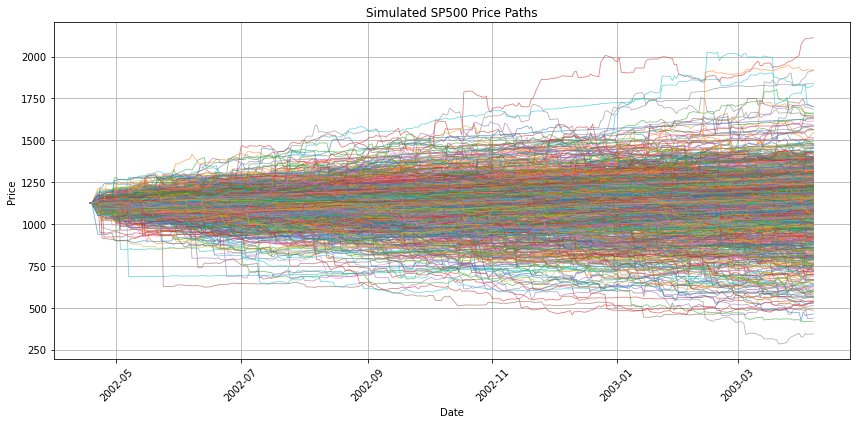

In [12]:
#NIG_CIR Parameters
kappa = 0.5391     # Mean reversion speed
eta = 1.5746       # Long-term mean
lambda_ = 1.8772   # Volatility
y0 = 1     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
alpha = 18.4815 #Tail heaviness parameter for the NIG process.
beta = -4.8412 #Asymmetry parameter for the NIG process.
delta = 0.4685 #Scale parameter for the NIG process.
starting_price = 1124.47
r = 0.019                                                                                               
q = 0.012
num_paths = 1000  # Number of trajectories
# Set the starting date for the x-axis
start_date = pd.to_datetime("2002-04-18")
dates = pd.date_range(start=start_date, periods=N + 1, freq='B')  # Business days only
# Initialize an array to store paths
paths = np.zeros((N + 1, num_paths))
paths[0] = starting_price  # Set initial price for all paths
u = -1*delta*(math.sqrt(alpha*alpha-(beta+1)**2) - math.sqrt(alpha*alpha-beta*beta)) #New u* for the risk-neutral correction
# Simulate each path
for i in range(num_paths):
    # Generate a new set of daily log returns for this trajectory
    time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
    prices = starting_price * np.exp(levy_process)
    risk_neutral_prices =  apply_risk_neutral (r, q, u, np.linspace(0, T, N), prices, kappa, eta, lambda_, y0) 
    paths[1:, i] = risk_neutral_prices  # Convert log returns to price path
# Plot the 100 simulated paths
plt.figure(figsize=(12, 6))
for i in range(num_paths):
    plt.plot(dates, paths[:, i], linewidth=0.8, alpha=0.6)
plt.title("Simulated SP500 Price Paths")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Call options pricing using Montecarlo simulation

### 2.1 Black-Scholes formula (benchmark of theoretical options' prices)

In [51]:
import math
from scipy.stats import norm

def black_scholes_dividend(S, K, T, r, sigma, q, option_type="call"):
    """
    Calculate the Black-Scholes price of a European call or put option on a dividend-paying stock.

    Parameters:
    - S (float): Current stock price
    - K (float): Option strike price
    - T (float): Time to expiration in years
    - r (float): Risk-free interest rate
    - sigma (float): Volatility of the underlying asset
    - q (float): Continuous dividend yield
    - option_type (str): "call" for call option or "put" for put option
    
    Returns:
    - float: Price of the option
    """
    # Calculate d1 and d2
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if option_type == "call":
        # Call option price
        option_price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        # Put option price
        option_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return option_price


### 2.2 Montecarlo simulation using NIG_CIR process

In [54]:
def get_montecarlo_nig_cir_call(kappa, eta, lambda_, y0, T, N, alpha, beta, delta, r, q, starting_price, strikes, num_paths):
    # Calculate the adjusted drift term (u*) for risk-neutral correction
    u = -1 * delta * (math.sqrt(alpha * alpha - (beta + 1) ** 2) - math.sqrt(alpha * alpha - beta * beta))
    risk_neutral_ = risk_neutral(r, q, u, N/252, kappa, eta, lambda_, y0)
    # Initialize a dictionary to store payoffs for each strike
    strike_payoffs = {strike: [] for strike in strikes}
    # Simulate each path
    for i in range(num_paths):
        # Generate a new set of daily log returns for this trajectory
        time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
        prices = starting_price * np.exp(levy_process) * risk_neutral_ #*Works only as a risk neutral correction for the final price
        # Calculate payoffs for each strike on the same price path
        final_price = prices[-1]
        for strike in strikes:
            payoff = max(final_price - strike, 0)  # Call option payoff formula
            strike_payoffs[strike].append(payoff)
    # Calculate the average payoff for each strike and return results
    option_prices = {strike: math.exp(-(r)*N/252)*statistics.mean(payoffs) for strike, payoffs in strike_payoffs.items()}
    return option_prices

def get_montecarlo_nig_call(N, alpha, beta, delta, r, q, starting_price, strikes, num_paths):
    t = [i / 252 for i in range(N)]
    # Initialize a dictionary to store payoffs for each strike
    strike_payoffs = {strike: [] for strike in strikes}
    # Calculate the risk neutral measure using Montecarlo
    risk_neutral_values = []
    # Simulate each path
    for i in range(num_paths):
        # Generate a new set of daily log returns for this trajectory
        time, levy_process = get_NIG(t, alpha, beta, delta)
        risk_neutral_values.append(math.exp(levy_process[-1]))
    risk_neutral_ = math.exp((r-q)*N/252) / statistics.mean(risk_neutral_values)
    # Calculate the option value using Montecarlo
    # Simulate each path
    for i in range(num_paths):
        # Generate a new set of daily log returns for this trajectory
        time, levy_process = get_NIG(t, alpha, beta, delta)
        prices = starting_price * np.exp(levy_process) * risk_neutral_ #*Works only as a risk neutral correction for the final price
        # Calculate payoffs for each strike on the same price path
        final_price = prices[-1]
        for strike in strikes:
            payoff = max(final_price - strike, 0)  # Call option payoff formula
            strike_payoffs[strike].append(payoff)
    # Calculate the average payoff for each strike and return results
    option_prices = {strike: math.exp(-(r)*N/252)*statistics.mean(payoffs) for strike, payoffs in strike_payoffs.items()}
    return option_prices

### 2.3 Comparison Black-Scholes with Levy's NIG_CIR Process

    Strike  Market Price  Black-Scholes Price  NIG_CIR Price  \
0     1025         146.5           137.706973     145.538060   
1     1100          96.2            92.910643      95.997273   
2     1125          81.7            80.518261      81.599749   
3     1150          68.3            69.369740      68.307679   
4     1175          56.6            59.420656      56.244394   
5     1200          46.1            50.611487      45.545100   
6     1225          36.9            42.871027      36.197764   
7     1250          29.3            36.119830      28.349782   
8     1275          22.5            30.273478      21.938495   
9     1300          17.2            25.245525      16.898599   
10    1325          12.8            20.950027      13.005146   

    BS Relative Error  NIG_CIR Relative Error  
0            0.060021                0.006566  
1            0.034193                0.002107  
2            0.014464                0.001227  
3            0.015662                0.

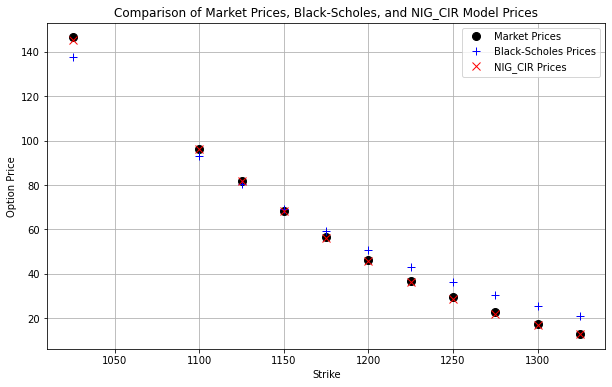

In [ ]:
# Given data for call options
strikes = [1025, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325]
market_prices = [146.50, 96.20, 81.70, 68.30, 56.60, 46.10, 36.90, 29.30, 22.50, 17.20, 12.80]
#Common paramters
N = 234 #Business days From 18th April 2002 to 21th March 2003
T_BS = N/252
T_NIG_CIR = 1 #Always one
# Black-Scholes parameters
r = 0.019
q = 0.012
S = 1124.47
sigma = 0.1812
# NIG_CIR parameters
kappa = 0.5391     
eta = 1.5746       
lambda_ = 1.8772   
y0 = 1                         
alpha = 18.4815
beta = -4.8412
delta = 0.4685     
num_paths = 10000
# Calculate Black-Scholes prices
bs_prices = [black_scholes_dividend(S, K, T_BS, r, sigma, q, option_type="call") for K in strikes]
# Calculate NIG_CIR prices
nig_cir_prices_dict = get_montecarlo_nig_cir_call(kappa, eta, lambda_, y0, T_NIG_CIR, N, alpha, beta, delta, r, q, S, strikes, num_paths)
nig_cir_prices = [nig_cir_prices_dict[strike] for strike in strikes]  # Ensure the order matches 'strikes'
# Create DataFrame to store strikes, market prices, Black-Scholes prices, and NIG_CIR prices
data_model = {
    'Strike': strikes,
    'Market Price': market_prices,
    'Black-Scholes Price': bs_prices,
    'NIG_CIR Price': nig_cir_prices
}
df = pd.DataFrame(data_model)
# Calculate ARPEs for each model
df['BS Relative Error'] = abs((df['Market Price'] - df['Black-Scholes Price']) / df['Market Price'])
df['NIG_CIR Relative Error'] = abs((df['Market Price'] - df['NIG_CIR Price']) / df['Market Price'])
# Compute ARPE for Black-Scholes and NIG_CIR
ARPE_bs = df['BS Relative Error'].mean() * 100
ARPE_nig_cir = df['NIG_CIR Relative Error'].mean() * 100
# Determine which model performs better
better_model = "Black-Scholes" if ARPE_bs < ARPE_nig_cir else "NIG_CIR"
improvement = abs(ARPE_bs - ARPE_nig_cir)
# Print the ARPEs and performance comparison
print(df)
print(f"\nAverage Relative Percentage Error (ARPE) - Black-Scholes: {ARPE_bs:.2f}%")
print(f"Average Relative Percentage Error (ARPE) - NIG_CIR: {ARPE_nig_cir:.2f}%")
print(f"\nThe {better_model} model is better by {improvement:.2f}%.")
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Strike'], df['Market Price'], 'o', label='Market Prices', markersize=8, color='black')
plt.plot(df['Strike'], df['Black-Scholes Price'], '+', label='Black-Scholes Prices', markersize=8, color='blue')
plt.plot(df['Strike'], df['NIG_CIR Price'], 'x', label='NIG_CIR Prices', markersize=8, color='red')
# Labels and title
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Comparison of Market Prices, Black-Scholes, and NIG_CIR Model Prices')
plt.legend()
plt.grid(True)
plt.show()
#Plot and save the DataFrame as a table
df_formatted = df.applymap(lambda x: "{:.3f}".format(x) if isinstance(x, float) and x not in df['Strike'].tolist() and x not in df['Market Price'].tolist() else x)
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, cellLoc='center', loc='center')
plt.savefig("options_NIG_CIR.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.close()

### 2.4 Comparison Black-Scholes with Levy's NIG Process (without time change)

    Strike  Market Price  Black-Scholes Price   NIG Price  BS Relative Error  \
0     1025         146.5           137.706973  147.412977           0.060021   
1     1100          96.2            92.910643   96.828418           0.034193   
2     1125          81.7            80.518261   82.216059           0.014464   
3     1150          68.3            69.369740   68.918095           0.015662   
4     1175          56.6            59.420656   57.009580           0.049835   
5     1200          46.1            50.611487   46.626230           0.097863   
6     1225          36.9            42.871027   37.756854           0.161816   
7     1250          29.3            36.119830   30.322273           0.232759   
8     1275          22.5            30.273478   24.133938           0.345488   
9     1300          17.2            25.245525   19.101207           0.467763   
10    1325          12.8            20.950027   15.085821           0.636721   

    NIG Relative Error  
0             

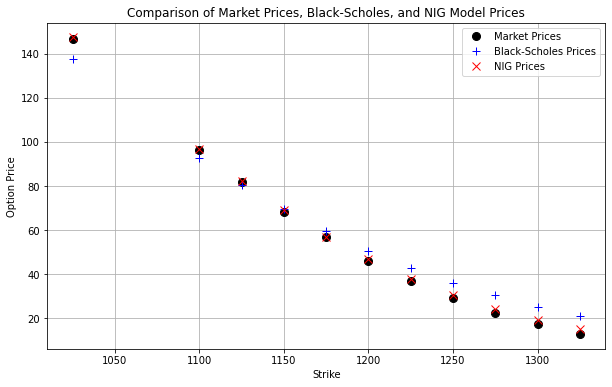

In [63]:
# Given data for call options
strikes = [1025, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325]
market_prices = [146.50, 96.20, 81.70, 68.30, 56.60, 46.10, 36.90, 29.30, 22.50, 17.20, 12.80]
#Common paramters
N = 234 #Business days From 18th April 2002 to 21th March 2003
T_BS = N/252
# Black-Scholes parameters
r = 0.019
q = 0.012
S = 1124.47
sigma = 0.1812
# NIG parameters (pag. 82)                      
alpha = 6.1882
beta = -3.8941
delta = 0.1622     
num_paths = 10000
# Calculate Black-Scholes prices
bs_prices = [black_scholes_dividend(S, K, T_BS, r, sigma, q, option_type="call") for K in strikes]
# Calculate NIG prices
nig_cir_prices_dict = get_montecarlo_nig_call(N, alpha, beta, delta, r, q, S, strikes, num_paths)
nig_cir_prices = [nig_cir_prices_dict[strike] for strike in strikes]  # Ensure the order matches 'strikes'
# Create DataFrame to store strikes, market prices, Black-Scholes prices, and NIG prices
data = {
    'Strike': strikes,
    'Market Price': market_prices,
    'Black-Scholes Price': bs_prices,
    'NIG Price': nig_cir_prices
}
df = pd.DataFrame(data)
# Calculate ARPEs for each model
df['BS Relative Error'] = abs((df['Market Price'] - df['Black-Scholes Price']) / df['Market Price'])
df['NIG Relative Error'] = abs((df['Market Price'] - df['NIG Price']) / df['Market Price'])
# Compute ARPE for Black-Scholes and NIG
ARPE_bs = df['BS Relative Error'].mean() * 100
ARPE_nig_cir = df['NIG Relative Error'].mean() * 100
# Determine which model performs better
better_model = "Black-Scholes" if ARPE_bs < ARPE_nig_cir else "NIG"
improvement = abs(ARPE_bs - ARPE_nig_cir)
# Print the ARPEs and performance comparison
print(df)
print(f"\nAverage Relative Percentage Error (ARPE) - Black-Scholes: {ARPE_bs:.2f}%")
print(f"Average Relative Percentage Error (ARPE) - NIG: {ARPE_nig_cir:.2f}%")
print(f"\nThe {better_model} model is better by {improvement:.2f}%.")
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Strike'], df['Market Price'], 'o', label='Market Prices', markersize=8, color='black')
plt.plot(df['Strike'], df['Black-Scholes Price'], '+', label='Black-Scholes Prices', markersize=8, color='blue')
plt.plot(df['Strike'], df['NIG Price'], 'x', label='NIG Prices', markersize=8, color='red')
# Labels and title
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Comparison of Market Prices, Black-Scholes, and NIG Model Prices')
plt.legend()
plt.grid(True)
plt.show()
#Plot and save the DataFrame as a table
df_formatted = df.applymap(lambda x: "{:.3f}".format(x) if isinstance(x, float) and x not in df['Strike'].tolist() and x not in df['Market Price'].tolist() else x)
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, cellLoc='center', loc='center')
plt.savefig("options_NIG.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.close()

### 2.5 Black-Scholes implied volatility

In [64]:
# Function to find the implied volatility using Brent's method
def implied_volatility_call_brent(price, S, K, T, r, q):
    # Objective function for the root finding
    def objective(sigma):
        return black_scholes_dividend(S, K, T, r, sigma, q, option_type="call") - price

    # Use brentq to find the root within a reasonable range of volatility
    try:
        return brentq(objective, 1e-5, 5.0)
    except ValueError:
        # Return NaN if no solution found within the interval
        return np.nan

    Strike Price  Market Price  Implied Volatility from market prices  \
0           1025         146.5                               0.206209   
1           1100          96.2                               0.189137   
2           1125          81.7                               0.183985   
3           1150          68.3                               0.178698   
4           1175          56.6                               0.174543   
5           1200          46.1                               0.170281   
6           1225          36.9                               0.166131   
7           1250          29.3                               0.162966   
8           1275          22.5                               0.158784   
9           1300          17.2                               0.155804   
10          1325          12.8                               0.152555   

    NIG CIR Price  Implied Volatility from NIG CIR price  
0      145.538060                               0.203514  
1    

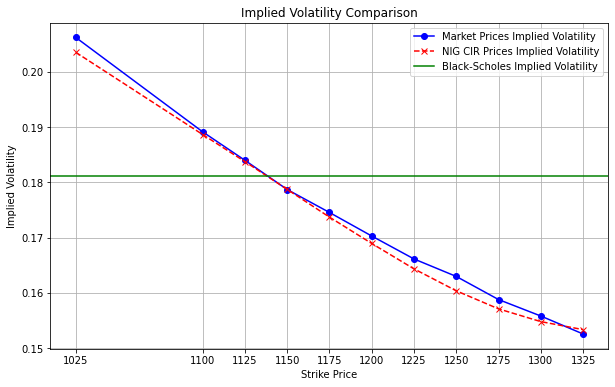

In [67]:
# Market data for the first set (market prices)
strikes = [1025, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325]
market_prices = [146.50, 96.20, 81.70, 68.30, 56.60, 46.10, 36.90, 29.30, 22.50, 17.20, 12.80]
# Market data for the second set (NIG CIR prices)
nig_cir_prices = data_model["NIG_CIR Price"]
# Paramters for Black-Scholes
r = 0.019
q = 0.012
S = 1124.47
N = 234 # business days until the options' maturity
T = N / 252
# Calculate implied volatilities for the first data set using Brent's method
implied_vols1 = [implied_volatility_call_brent(price, S, K, T, r, q) for price, K in zip(market_prices, strikes)]
# Calculate implied volatilities for the second data set using Brent's method
implied_vols2 = [implied_volatility_call_brent(price, S, K, T, r, q) for price, K in zip(nig_cir_prices, strikes)]
# Create a DataFrame to display the results
data = {
    'Strike Price': strikes,
    'Market Price': market_prices,
    'Implied Volatility from market prices': implied_vols1,
    'NIG CIR Price': nig_cir_prices,
    'Implied Volatility from NIG CIR price': implied_vols2
}
results_table = pd.DataFrame(data)
# Display the results table
print(results_table)
# Plotting the implied volatilities
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols1, marker='o', linestyle='-', color='b', label='Market Prices Implied Volatility')
plt.plot(strikes, implied_vols2, marker='x', linestyle='--', color='r', label='NIG CIR Prices Implied Volatility')
plt.axhline(y=sigma, color='g', linestyle='-', label='Black-Scholes Implied Volatility') #BS implied vol (constant)
plt.title('Implied Volatility Comparison')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.xticks(strikes)
plt.grid()
plt.legend()
plt.show()
#Plot and save the DataFrame as a table
df_formatted = results_table.applymap(lambda x: "{:.3f}".format(x) if isinstance(x, float) and x not in df['Strike'].tolist() and x not in df['Market Price'].tolist() else x)
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, cellLoc='center', loc='center')
plt.savefig("implied_vol.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.close()

## 3. Exotic option pricing using Montecarlo simulation

By Monte-Carlo simulation, calculate the price of an exotic Barrier option of the type “down-and-out barrier call” (DOBC), which is worthless unless its minimum remains above some low barrier H, in which case it retains the structure of a European call with strike K (see Schoutens, chapter 9). Take the time to maturity T to be 12 months, the strike K = S0 = 1124.47, the barrier H value is given by HDOB = 0.8 × S0 and compare the price obtained with the ones in Table 9.1 (Chapter 9 of Schoutens). You can consider 2000 simulations of paths and 300 equally small time steps.

In [74]:
def get_montecarlo_nig_cir_dobc(kappa, eta, lambda_, y0, T, N, alpha, beta, delta, r, q, starting_price, strike, barrier, num_paths):
    num_stays_activated = 0
    num_positive_payoffs_given_activation = 0
    # Calculate the adjusted drift term (u*) for risk-neutral correction
    u = -1 * delta * (math.sqrt(alpha * alpha - (beta + 1) ** 2) - math.sqrt(alpha * alpha - beta * beta))
    risk_neutral_ = risk_neutral(r, q, u, N/252, kappa, eta, lambda_, y0)
    # Initialize a dictionary to store payoffs for each strike
    payoffs=[]
    # Simulate each path
    for i in range(num_paths):
        # Generate a new set of daily log returns for this trajectory
        time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
        prices = starting_price * np.exp(levy_process)
        risk_neutral_prices =  apply_risk_neutral (r, q, u, np.linspace(0, T, N), prices, kappa, eta, lambda_, y0) 
        # Calculate payoffs for each strike on the same price path
        barrier_breached = any(price <= barrier for price in risk_neutral_prices)
        if not barrier_breached:
            final_price = risk_neutral_prices[-1]
            payoff = max(final_price - strike, 0)  # Call option payoff formula
            payoffs.append(payoff)
            num_stays_activated=num_stays_activated+1
            if payoff>0:
                num_positive_payoffs_given_activation = num_positive_payoffs_given_activation+1
        else:
            payoffs.append(0)
    # Calculate the average payoff for each strike and return results
    option_price = {strike: math.exp(-(r)*N/252)*statistics.mean(payoffs) if payoffs else 0}
    return {
        'Option Price': option_price,
        'Probability of remaining active': num_stays_activated/num_paths,
        'Conditional probability of positive payoff if remains active': num_positive_payoffs_given_activation/num_stays_activated
    }

In [87]:
#Common paramters
N = 252 # Option expriying in one year
T_NIG_CIR = 1 #Always one
# Black-Scholes parameters
r = 0.019
q = 0.012
S = 1124.47
# NIG_CIR parameters
kappa = 0.5391     
eta = 1.5746       
lambda_ = 1.8772   
y0 = 1                         
alpha = 18.4815
beta = -4.8412
delta = 0.4685     
num_paths = 500
# Calculate DOBC price
dobc_price = get_montecarlo_nig_cir_dobc(kappa, eta, lambda_, y0, T_NIG_CIR, N, alpha, beta, delta, r, q, S, S, 0.8*S, num_paths)
print(dobc_price)
print(f"Schoutens book price: 86.18")

{'Option Price': {1124.47: 96.77018481943927}, 'Probability of remaining active': 0.836, 'Conditional probability of positive payoff if remains active': 0.7272727272727273}
Schoutens book price: 86.18
